# Machine Learning in Python - Project 1

by Mia WU(s2025818) & Huanyu Su(s2171849) & Zhongtian Zheng(s2139149) & Peiran Zhang(s2184444)

## 0. Setup

In [40]:
# Add any additional libraries or submodules below

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
#import sklearn
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# The regression tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import re

In [41]:
""" import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks/mlp/project1')
!ls """

" import os\nfrom google.colab import drive\n\ndrive.mount('/content/drive')\nos.chdir('drive/My Drive/Colab Notebooks/mlp/project1')\n!ls "

In [42]:
# Model_fit function was created by Colin Rundel & David Elliott & Kit Searle from MLP workshop5

# Define to evaluating model effectiveness

def model_fit(m, X, y, plot = False):
    """Returns the root mean squared error of a fitted model based on provided X and y values.
    
    Args:
        m: sklearn model object
        X: model matrix to use for prediction
        y: outcome vector to use to calculating rmse and residuals
        plot: boolean value, should fit plots be shown 
    """
    
    y_hat = m.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        plt.hlines(y=0, xmin=np.min(y), xmax=np.max(y), linestyles='dashed', alpha=0.3, colors="black")
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

# Define to create features that this project need
def create_features(X,times=6):
    """Returns new feature matrix.
    
    Args:
        X: matrix 
    """
    X_ = X.copy()
    # Part 1&2
    X_["two_parts"] = X_.episode_name.str.contains("Parts 1&2", case=False,regex=False)

    # Number of episodes, too many episodes can be tiring?
    episode_count = X_[["season"]].groupby("season").size().reset_index().rename(columns={0:'episode_num'})
    X_ = X_.merge(episode_count)

    # Split the air data into year, month. (correlated with season)
    air_date = pd.to_datetime(X_['air_date'])
    #X_['air_date_year'] = air_date.dt.year
    X_['air_date_month'] = air_date.dt.month.astype('category')
    X_['air_date_day'] = air_date.dt.strftime('%A').astype('category')

    # Writer 
    X_["writer_one"] = X_.writer.str.split(';')
    X_["writer_num"] = X_.writer_one.apply(lambda x: len(x))
    X_["writer_one"] = X_.writer_one.apply(lambda x: x[0])
    writer_dat_ = X_.writer_one.explode().value_counts()
    writer_dat_ =writer_dat_.reset_index().rename(columns={'index': 'writer_one','writer_one': 'Counts'})

    # Only experienced writer (times >=k), otherwise = "Unexperienced writer"
    writer_dat_.loc[(writer_dat_.Counts >= times)  == False,"writer_one"] = "Inexperienced writer"
    experienced_writer = writer_dat_["writer_one"].unique()
    X_["writer_one"] = X_["writer_one"].apply(lambda x: x if x in experienced_writer else "Inexperienced").astype('category')
    
    # Samely, create features for director!
    X_["director_one"] = X_.director.str.split(';')
    X_["director_num"] = X_.director_one.apply(lambda x: len(x))
    X_["director_one"] = X_.director_one.apply(lambda x: x[0])
    director_dat_ = X_.director_one.explode().value_counts()
    director_dat_ = director_dat_.reset_index().rename(columns={'index': 'director_one','director_one': 'Counts'})

    # Only experienced director (times >=k), otherwise = "Unexperienced director"
    director_dat_.loc[(director_dat_.Counts >= times)  == False,"director_one"] = "Inexperienced director"
    experienced_director = director_dat_["director_one"].unique()
    X_["director_one"] = X_["director_one"].apply(lambda x: x if x in experienced_director else "Inexperienced").astype('category')
    
    # Create char_num, variables named after character's name.
    features_ = X_.main_chars.str.split(';').sort_index()
    X_['main_chars_split'] = X_.main_chars.str.split(';')
    """
    char_dat_ = X_.main_chars.str.split(';').explode().value_counts()
    char_dat_ =char_dat_.reset_index().rename(columns={'index': 'Name','main_chars': 'Counts'})
    X_['char_num'] = X_['main_chars_split'].apply(lambda x: len(x))
    def find_name(x,*name): # *name expect a tuple here, we take only the first element!
        return name[0] in x

    for name in char_dat_['Name']:
        X_[name] = features_.apply(find_name,args=(name,))  # Use (,), or a string will be split into characters.
        X_[name] = X_[name].astype('category') """

    # Drop unwanted variable!
    X_.drop(['season','episode','episode_name',
    'director','writer',
    'air_date', 'air_date_month',
    'main_chars','main_chars_split',
    'n_words'],axis = 1,inplace=True)
    return X_

In [43]:
# Load data
d = pd.read_csv("the_office.csv")

## 1. Introduction

The Office, the most popular American mockumentary sitcom covering the daily work lives of employees at a paper company, was met with mixed reviews during its nine seasons. To give advice for creating a special reunion episode of 'The Office' with high ratings, we use data and numerous statistical models to analyze character stats,relationships and their influence on audience ratings. After comparison, the most explanatory model was about to make a proposal to NBC Universal to produce a popular reunion episode.


We create four models which are Linear Model with Lasso, Regression Trees, Support Vector Regression and Polynomial Regression to find the relationship among iMDB rating and numerous factors, which are episode duration, spoken lines (the number of spoken lines in total and in per main characters), if there are some Guest Stars in an episode, the number of directions, who is the first director and writer in an episode. The results show that Regression Tree, which will describe in part3, gives the minimum root mean squared error (rmse) and has the best explanation.

**Additional Data:**
To construct an optimal model that can be explained, we take imdb_rating as the dependent variable and introduce a set of explanatory variables derived from the data provided and externally searched variables. 
The additional data information show as following:

**1.The-office-lines**

*From: https://www.kaggle.com/nasirkhalid24/the-office-us-complete-dialoguetranscript*

Data used to calculate the number of lines spoken by the main charaters in each eposode and can be used to analyze the impact of actors on each episode's imdb_rating. 
The dataset includes the following columns:
* `season` - Season number of the episode
* `episode` - Episode number within a season
* `title` - same as column ‘Episode name’
* `speaker` - character’s name who speak the line behind
* `line` - spoken lines

**2.The-office-series**

*From: https://www.kaggle.com/nehaprabhavalkar/the-office-dataset*

Data used to analyze the impact of each episode running time and special guests on each episode's imdb_rating.
The dataset includes the following columns:
* `Season` - Season number of the episode
* `Episode` - Episode number within a season
* `EpisodeTitle` - same as column ‘Episode name’
* `Ratings` - imdb audience rating
* `Votes` - the number of voting audience
* `Duration` - Episode Running Time
* `GuestStars` - Influential special guests, split by ‘,’


## 2. Exploratory Data Analysis and Feature Engineering

In this part we include a detailed discussion and visualizations of data. 

To analyze the variables associated with a play's rating, we can think that perhaps this is related to the actors who appear in it. A good director or writer can also make the rating go up, so we can, for example, look at each of the individual characters, directors, writers, etc., as a FEATURE when exploring data analysis.

We complete this section in three steps, which are:

2.1 Data analysis and visualizations (especially in main_characters,directors and writers) 

2.2 Create feature engineering



### 2.1 Data analysis and visualizations (especially in main_characters,directors and writers) 



#### 2.1.1 Data preprocessing and overall analysis


After importing *the_office.csv* file and converting it to dataframe, we first clean it to avoid some mistakes from data collection. 

We can figure out that the author and director variables contain several names, some of which are the same. However, they have different orders, and we modify the order of these objects so that they are consistent in later analyses. And to make our analysis more specific with episode duration, we add (part1&2) in the episode name, A.A.R.M and Finale, which duration is much longer than others.

In [44]:
# Adjust the order of the variables
d.loc[d.director == "Lee Eisenberg;Gene Stupnitsky",'director'] = "Gene Stupnitsky;Lee Eisenberg"
d.loc[d.writer == "Lee Eisenberg;Gene Stupnitsky",'writer'] = "Gene Stupnitsky;Lee Eisenberg"
d.loc[d.director == "Michael Schur;Lee Eisenberg;Gene Stupnitsky",'director'] = "Gene Stupnitsky;Lee Eisenberg;Michael Schur"
d.loc[d.director == "Greg Daneils",'director'] = "Greg Daniels"
d.loc[d.director == "Paul Lieerstein",'director'] = "Paul Lieberstein"

# A.A.R.M is found out to have two episodes. 
d.loc[d.episode_name == "A.A.R.M", "episode_name"] = "A.A.R.M (Parts 1&2)"
d.loc[d.episode_name == "Finale", "episode_name"] = "Finale (Parts 1&2)"
# Use all data in the period of Exploratory Analysis.
data = d.copy()

To better analyze the data, we found the dataset of lines `The-office-Lines-V4.csv` from Kaggle and modified some typographical errors (for example, comparing the original dataset, we found that the dataset had incorrectly entered some "Michael" as "Michel").

In [45]:
lines = pd.read_csv('The-Office-Lines-V4.csv',usecols=[0,1,2,3,4,5])
lines["speaker_clean"] = lines.speaker.str.replace(".*(Michael|Michel).*","Michael",regex=True) # Modify some typo

In [46]:
lines.loc[(lines.speaker == "Michael") & lines.season == 1].head(5) # Check if any typo

,season,episode,title,scene,speaker,line,speaker_clean
0,1,1,Pilot,1,Michael,All right Jim. Your quarterlies look very good...,Michael
2,1,1,Pilot,1,Michael,So you've come to the master for guidance? Is ...,Michael
4,1,1,Pilot,1,Michael,"All right. Well, let me show you how it's done.",Michael
5,1,1,Pilot,2,Michael,"Yes, I'd like to speak to your office manager...",Michael
6,1,1,Pilot,3,Michael,"I've, uh, I've been at Dunder Mifflin for 12 y...",Michael


Lines per episode, we want to record how many lines of dialogue each character speaks. As we can observe, some characters such as Michael speak significantly more lines. Even if the total number of lines is the same, having a character say more makes a difference.

In [47]:
# Find out the 5 characters with most lines in each episode
lines_per_episode = lines.groupby(['season','episode','speaker_clean'])[['line']].count().reset_index()
# Similarly, we can get the 5 characters with most lines in every season
lines_per_season = lines.groupby(['season', 'speaker_clean'])[['line']].count().reset_index().sort_values(by =["season","line"],ascending=[True,False])
lines_per_season = lines_per_season.groupby("season").head(5)
lines_per_season.head(10)

,season,speaker_clean,line
14,1,Michael,491
5,1,Jim,228
2,1,Dwight,208
17,1,Pam,162
6,1,Katy,58
106,2,Michael,1849
63,2,Dwight,815
85,2,Jim,744
114,2,Pam,611
84,2,Jan,234


Below is a histogram of the number of lines spoken by each character in each season, and we have plotted the top five bars. As can be seen, Michael has the most lines in the first seven seasons but has not appeared since season eight, whereas Dwight has appeared in every season, and when modeling later we can focus on whether Michael's appearance has an impact on the rating.

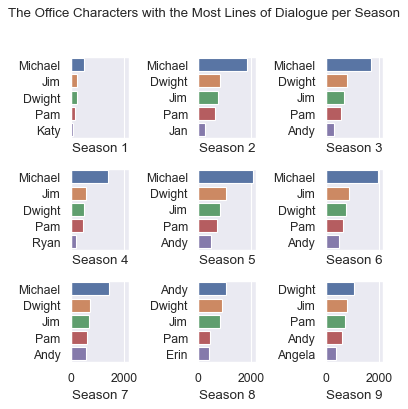

In [48]:
nrow=3
ncol=3
fig, axes = plt.subplots(nrow, ncol, figsize=(5,5),sharex = True)
fig.suptitle("The Office Characters with the Most Lines of Dialogue per Season", fontsize=12, y=1.02)
axes = axes.flatten()
for s in range(0, 9):
    df = lines_per_season.loc[lines_per_season['season'] == s+1,['speaker_clean','line']]
    sns.barplot(data=df, y="speaker_clean",x="line",ax=axes[s])
    axes[s].set(ylabel="",
       xlabel="Season " + str(s+1) )
plt.tight_layout()

We then loaded the dataset `the_office_series.csv` from which we extracted the duration of each episode and whether there were any guest stars.

In [49]:
# load data
series = pd.read_csv('the_office_series.csv',index_col = 0)

sns.set(rc = {'figure.figsize':(8,5)})
duration = series.drop(['About','Ratings','Votes','Viewership','Director','Writers'], axis=1).fillna(False)
duration.loc[duration.GuestStars != False, "GuestStars"] = True
duration.Date = pd.to_datetime(duration.Date)
duration.loc[duration.Date.duplicated(keep=False)]
duration.loc[duration.EpisodeTitle == 'Niagara: Part 1', "EpisodeTitle"] = "Niagara (Parts 1&2)"
duration.loc[duration.EpisodeTitle == 'The Delivery: Part 1', "EpisodeTitle"] = "The Delivery (Parts 1&2)"
duration.loc[duration.Date.duplicated(keep=False)]
duration.drop([95,108],inplace =True)
duration.reset_index(drop = True,inplace=True)

The corresponding duration data for each character was added to the exploration dataset.

In [50]:
data = d.copy()
data = pd.concat([duration.loc[:,["Duration","GuestStars"]],data],axis =1)

The scatterplot below shows that the length of each episode is mainly concentrated in the 20-30 minute range. Most longer shows are broadcast in two parts on the same day (quite reasonable); the ratings for the two composite parts are significantly higher than for the single episode parts, and reviews for shows with featured stars are considerably higher.

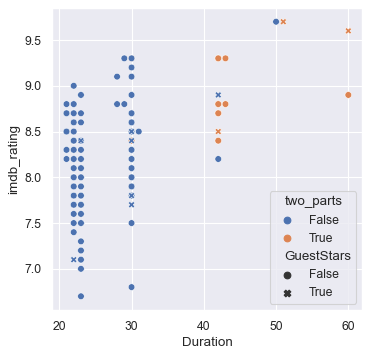

In [51]:
fig, axes = plt.subplots(figsize=(5,5),sharex = True)
data["two_parts"] = data.episode_name.str.contains("Parts 1&2", case=False,regex=False)
sns.scatterplot(data=data, x = "Duration", y = "imdb_rating", hue ="two_parts", style = "GuestStars")
None

#### 2.1.2 Main characters analysis

We started by looking at the main characters. Often people choose to watch a show because it has a specific actor in it, so we decided to count the number of episodes each main character appeared in and then analyze whether this affected the IMDb rating.
In the first step, we used the following bar chart to show the number of times the main characters appeared in each episode.. We find that Dwight seems in every season, so that we will exclude him later in our study of the relationship between ratings and cast appearances.

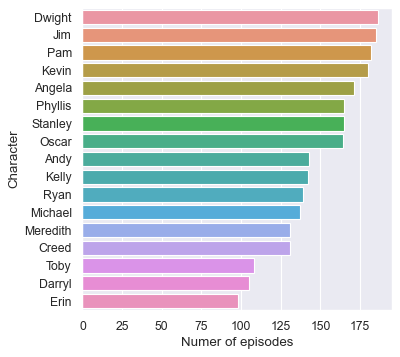

In [52]:
# feature engineering
features = data.main_chars.str.split(';').sort_index()
data['main_chars_split'] = data.main_chars.str.split(';')
char_dat = data.main_chars.str.split(';').explode().value_counts()

sns.set(rc = {'figure.figsize':(5,5)})
char_dat =char_dat.reset_index().rename(columns={'index': 'Name','main_chars': 'Counts'})
sns.barplot(y='Name',x='Counts',data=char_dat)
ax = plt.gca()
ax.set(ylabel="Character",
       xlabel="Numer of episodes")
None

We wanted to know if the ratings were related to the appearance of characters in each season, so we drew the following line graph. Each color represents a season, with "False" meaning the actor did not appear in that season, and "True" meaning the actor appeared in that episode. As you can see,Michael did not appear in the final two seasons until the final episode and saw a precipitous drop in ratings while peaking again on his return. Therefore, we can focus on the significance of whether Michael appeared or not in subsequent modeling.


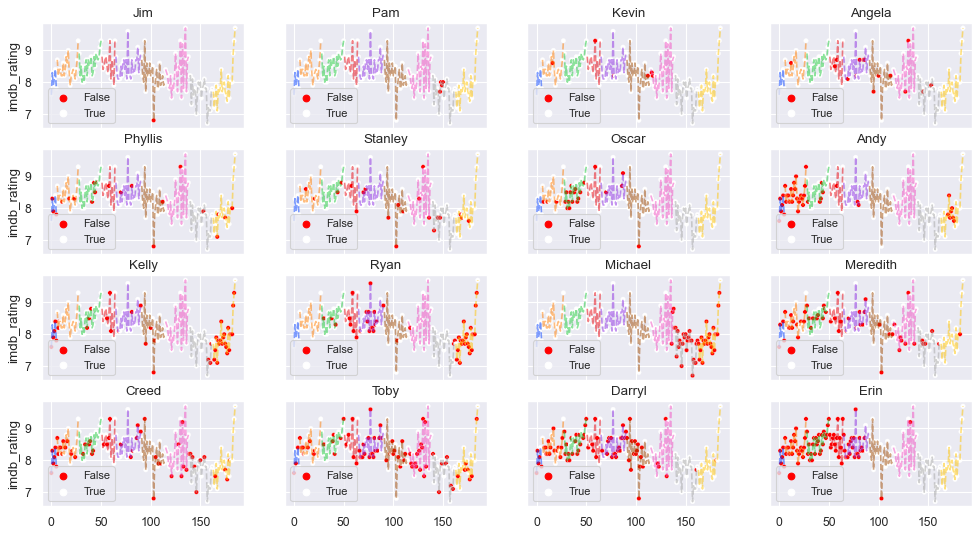

In [53]:
# We can either add a column counting total actor, it may ignore some BIG STAR
sns.set(rc = {'figure.figsize':(15,8)})
def find_name(x,*name): # *name expect a tuple here, we take only the first element!
    return name[0] in x

for name in char_dat['Name']:
    data[name] = features.apply(find_name,args=(name,))  # Use (,), or a string will be split into characters.


fig,ax = plt.subplots(4,4,sharex=True,sharey=True)
ax = ax.flatten() 

data.Dwight = data.Dwight.astype("category").cat.add_categories(['False'])
for i,name in enumerate(char_dat['Name'][1:]):
    sns.lineplot(data=data,x=data.index,y="imdb_rating",ax=ax[i],legend=False,
    palette = sns.color_palette("bright", 9),hue='season',linestyle ="--",alpha = 0.5)    
    sns.scatterplot(data=data, x=data.index, y="imdb_rating", ax=ax[i], palette=["red","white"], legend='full',hue=name, s = 16)
    sns.move_legend(ax[i], "lower left")
    ax[i].set_title(name)
    ax[i].legend(fontsize='10')

rating<=7


,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Andy,Kelly,Ryan,Michael,Meredith,Creed,Toby,Darryl,Erin,chars_num
103,30,False,6,14,The Banker,Jeffrey Blitz,Jason Kessler,6.8,2288,2010-01-21,...,True,False,True,True,False,False,True,False,False,8
146,23,False,8,8,Gettysburg,Jeffrey Blitz,Robert Padnick,7.0,1584,2011-11-17,...,True,True,True,False,True,False,False,True,True,14
157,23,False,8,19,Get The Girl,Rainn Wilson,Charlie Grandy,6.7,1642,2012-03-15,...,True,True,True,False,True,True,True,True,True,16


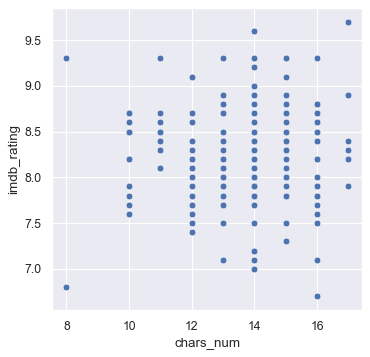

In [54]:
# Count the number of main chars.
data['chars_num'] = data.main_chars_split.apply(lambda x: len(x))
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=data, x='chars_num', y="imdb_rating")
print("rating<=7")
data.loc[(data.imdb_rating<=7)]

#### 2.1.3 Directors analysis

Next, we will examine the relationship between the director and the rating. We counted the episodes in which the directors were involved and calculated their average ratings, ranking them in descending order of rating to obtain a scatter plot. We can see from the graph that Harold Ramis has the highest average rating, but only three shots, which may not prove that his involvement has a significant relationship with ratings. On the other hand, among the directors with a rating of more than 8.5, Paul Feig, Ken Kwapis, and Greg Daniels have high ratings and have at least 12 episodes, so perhaps we can assume that they have a significant relationship with the rating.

C:\Users\ZHONGT~1\AppData\Local\Temp/ipykernel_37652/3003488680.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  scat_plt.set_xticklabels(dir_dat_rating.index, rotation=45, horizontalalignment='right')


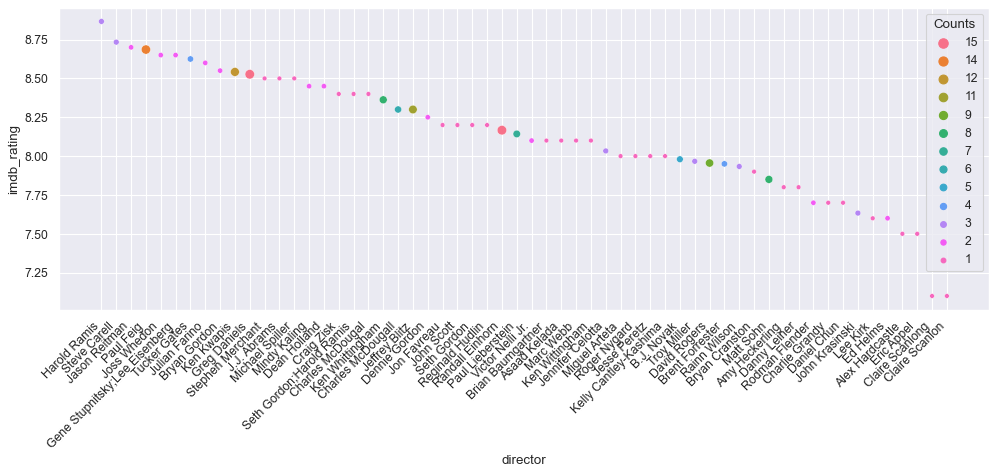

In [55]:
# there are values like A;B, B;A
data.director.loc[data.director =='Gene Stupnitsky;Lee Eisenberg']
dir_dat = data.director.explode().value_counts()
dir_dat =dir_dat.reset_index().rename(columns={'index': 'director','director': 'Counts'})

sns.set(rc = {'figure.figsize':(15,5)})
avg_rating = data[['director','imdb_rating']].groupby("director").mean()

dir_dat_rating = dir_dat.set_index("director").join(avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
dir_dat_rating.Counts = dir_dat_rating.Counts.astype('category')
dir_dat_rating.Counts = dir_dat_rating.Counts.cat.reorder_categories(dir_dat.Counts.unique())
# More productions, bigger size of the markers.
scat_plt = sns.scatterplot(data=dir_dat_rating, x=dir_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
scat_plt.set_xticklabels(dir_dat_rating.index, rotation=45, horizontalalignment='right')
None


Likewise, since the director was considered, the scriptwriter followed the logic of such a treatment. After sorting, we find that Greig Dianels, Gene Stupnitsky, Lee Eisenberg, and others maintain a high level of involvement in the episodes and a high average ranting, which can be considered in our subsequent modeling.

#### 2.1.4 Writers analysis

In [56]:
writer_dat = data.writer.explode().value_counts()
writer_dat = writer_dat.reset_index().rename(columns={'index': 'writer','writer': 'Counts'})

sns.set(rc = {'figure.figsize':(15,5)})
writer_avg_rating = data[['writer','imdb_rating']].groupby("writer").mean()

writer_dat_rating = writer_dat.set_index("writer").join(writer_avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
writer_dat_rating.Counts = writer_dat_rating.Counts.astype('category')
writer_dat_rating.Counts = writer_dat_rating.Counts.cat.reorder_categories(writer_dat.Counts.unique())
# More productions, bigger size of the markers.
# scat_plt2 = sns.scatterplot(data=writer_dat_rating, x=writer_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
# scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')
None

Considering that there may be many writers in the same set, we will make the following scatter plot considering only the first author. At that point, B.J Novak and Mindy Kailing stand out more clearly than in the above plot, and this treatment of the data seems a little more scientific, after which we will treat it as such for subsequent analysis.

C:\Users\ZHONGT~1\AppData\Local\Temp/ipykernel_37652/3699701290.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')


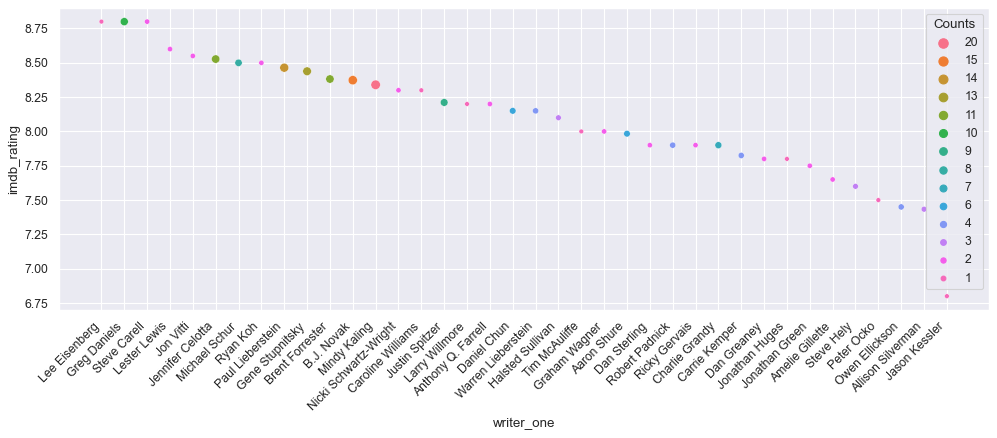

In [57]:
data["writer_one"] = data.writer.str.split(';')
data["writer_one"] = data.writer_one.apply(lambda x: x[0])
writer_dat = data.writer_one.explode().value_counts()
writer_dat =writer_dat.reset_index().rename(columns={'index': 'writer_one','writer_one': 'Counts'})

sns.set(rc = {'figure.figsize':(15,5)})
writer_avg_rating = data[['writer_one','imdb_rating']].groupby("writer_one").mean()
writer_dat_rating = writer_dat.set_index("writer_one").join(writer_avg_rating).sort_values("imdb_rating",ascending =False)
# Change the type of 'Counts' into category.
writer_dat_rating.Counts = writer_dat_rating.Counts.astype('category')
writer_dat_rating.Counts = writer_dat_rating.Counts.cat.reorder_categories(writer_dat.Counts.unique())
# More productions, bigger size of the markers.
scat_plt2 = sns.scatterplot(data=writer_dat_rating, x=writer_dat_rating.index,y="imdb_rating",hue="Counts",size="Counts")
scat_plt2.set_xticklabels(writer_dat_rating.index, rotation=45, horizontalalignment='right')
None 

To differentiate the weight of writers, we mark writers with more than or equal to 4 occurrences as "Experienced" and those with less than 4 occurrences as "inexperienced", and output all the different writers that have appeared.

In [58]:
times = 4
writer_dat["Experienced"] = writer_dat.Counts >= times 
writer_dat.loc[writer_dat.Experienced == False, "writer_one"] = "Inexperienced writer"
writer_dat.writer_one.unique()

array(['Mindy Kaling', 'B.J. Novak', 'Paul Lieberstein',
       'Gene Stupnitsky', 'Jennifer Celotta', 'Brent Forrester',
       'Greg Daniels', 'Justin Spitzer', 'Michael Schur',
       'Charlie Grandy', 'Aaron Shure', 'Daniel Chun',
       'Warren Lieberstein', 'Robert Padnick', 'Carrie Kemper',
       'Owen Ellickson', 'Inexperienced writer'], dtype=object)

We used the to_datetime function in the datetime package to convert the original air date of episode into years and months for subsequent modelling and analysis.

In [59]:
from datetime import datetime
air_date = pd.to_datetime(data['air_date'])
data['air_date_year'] = air_date.dt.year
data['air_date_month'] = air_date.dt.month

#### 2.1.5 Spoken lines analysis

Using the data we loaded from `The-office-Lines-V4.csv` earlier, we strung the line data together with the given data. We now have data on how many lines each character speaks in each episode.

In [60]:
char_names =char_dat['Name'].values
lines_per_episode = lines_per_episode.loc[lines_per_episode.speaker_clean.apply(lambda x: x in char_names),:]
lines_per_episode.reset_index(drop=True,inplace=True)
wide_lines_per_episode =  lines_per_episode.pivot(index=['season','episode'],columns=['speaker_clean'],values=['line']).fillna(value=0)
wide_lines_per_episode = wide_lines_per_episode.droplevel([0], axis=1)
wide_lines_per_episode.reset_index(level=["season","episode"],inplace=True)
wide_lines_per_episode.rename_axis(None,axis=1,inplace=True)
wide_lines_per_episode =  wide_lines_per_episode.add_suffix("_lines")
if len(data.columns) <=40:
    data = data.merge(wide_lines_per_episode,left_on=["season","episode"],right_on =["season_lines","episode_lines"]).drop(["season_lines","episode_lines"],axis=1)

#### 2.1.6 Guest Star analysis

Using the histogram we look at the relationship between gueste stars and ratings and we find that in the top band the appearance of gueste stars seems to play a more significant role, however in the 7.5 to 8.5 band the presence or absence of gueste stars does not seem to change the distribution of ratings, perhaps it only serves as icing on the cake?

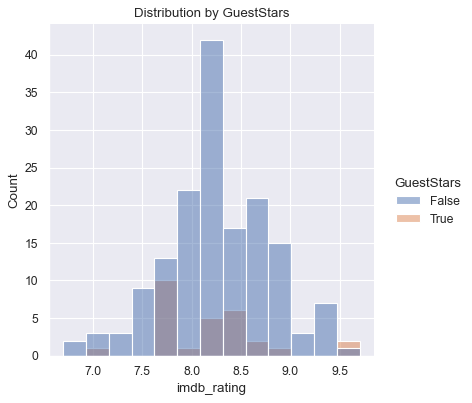

In [61]:
sns.set(rc = {'figure.figsize':(5,5)})
sns.displot(data=data,x="imdb_rating",hue="GuestStars")
plt.title("Distribution by GuestStars")
None

#### 2.1.7 Correlation analysis

Below we show the correlation between the original 13 variables using a heat map. Therefore, we aim to study rating and look primarily at the relationship between imdb_rating and the other variables. We can see that duration and total_votes have a significant effect on rating. Perhaps duration means richer content and better ratings? We don't know yet, but the total_votes variable, despite having the strongest correlation, doesn't seem to be taken into account, as the voting always starts when the show is already out, when the number of votes should be linked to the publicity and other reasons (perhaps because the investors have more confidence in the show and therefore invest more?) . We cannot confirm a direct relationship between the two, and it is not suitable for direct inclusion in the model, but perhaps it could be used as a weighting parameter.

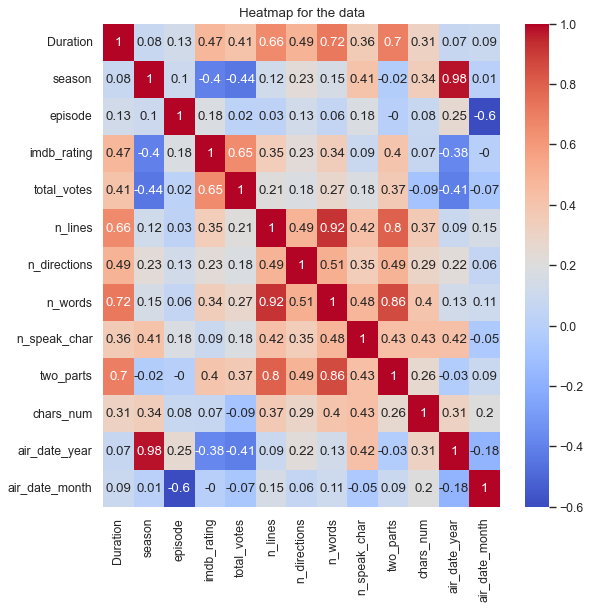

In [62]:
fig1,ax1 = plt.subplots(1,1,figsize = (8,8))
# Columns about characters.
cols_char = wide_lines_per_episode.columns[2:].tolist() + char_dat["Name"].tolist()
train_corr = data.drop(cols_char,axis=1).corr().round(2)
upper_triangle = np.triu(train_corr)  # The upper triangle will be 1 while the remain are 0.as_integer_ratio
# The cells where values take 1 while be hidden in heatmap
sns.heatmap(train_corr,annot=True,cmap='coolwarm',ax=ax1)
plt.title('Heatmap for the data')
plt.show()

This graph shows the relationship between rating and actor line count, and as we found in our previous research, Michael has the strongest correlation (after all, ratings have dropped significantly since his leave).

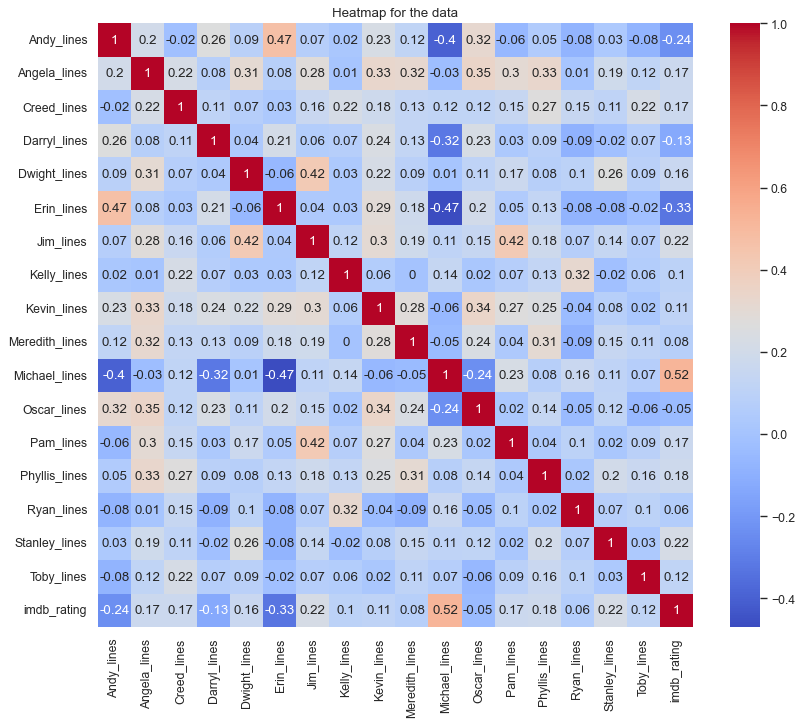

In [63]:
fig2,ax2 = plt.subplots(1,1,figsize = (12,10))
# Columns about characters
train_corr = data.loc[:, wide_lines_per_episode.columns[2:].tolist() + ["imdb_rating"]].corr().round(2)
upper_triangle = np.triu(train_corr)  # The upper triangle will be 1 while the remain are 0.as_integer_ratio
# The cells where values take 1 while be hidden in heatmap
sns.heatmap(train_corr,annot=True,cmap='coolwarm',ax=ax2)
plt.title('Heatmap for the data')
plt.show()

In preparation for the next feature engine, we decided to add new columns from external data - Duration, lines of each character, presence of Gueststar. Feature Engineering with given data - Character's presence: T/F, air_year (strongly correlated with season), air_month (correlated with episode), writer_one (the first writer), director_one (the first director)

In [64]:
if len(d.columns) <= 20:
    # ADD duration and GuestStars
    d = pd.concat([duration.loc[:,["Duration","GuestStars"]], d],axis =1)
    # ADD how many lines each characters speak
    d = d.merge(wide_lines_per_episode,left_on=["season","episode"],right_on =["season_lines","episode_lines"]).drop(["season_lines","episode_lines"],axis=1)
d.head(3)

,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Kelly_lines,Kevin_lines,Meredith_lines,Michael_lines,Oscar_lines,Pam_lines,Phyllis_lines,Ryan_lines,Stanley_lines,Toby_lines
0,23,False,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,...,0.0,1.0,0.0,82.0,3.0,40.0,2.0,8.0,5.0,0.0
1,23,False,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,...,2.0,8.0,0.0,75.0,13.0,12.0,0.0,4.0,5.0,2.0
2,22,False,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,...,0.0,6.0,3.0,55.0,9.0,32.0,0.0,1.0,6.0,0.0


### 2.2 Create feature engineering

To facilitate the construction of our dataset, we have defined `create_feature` function (show in set up section) for the processing of features, which takes the original data and the additional data we refer to and processes it into the final dataset we need for training and testing, and lists the data we don't need so that we can change it directly in the function if we need to refer to external data styles.

The following is a list of the variables we need to use.

In [65]:
crt = FunctionTransformer(create_features)
y = d.imdb_rating
X = d.drop(['imdb_rating','total_votes'],axis=1)
X = crt.fit_transform(X)
weights_by_votes = d.total_votes
X.GuestStars = X.GuestStars.astype("category")
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186 entries, 0 to 185
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Duration        186 non-null    int64   
 1   GuestStars      186 non-null    category
 2   n_lines         186 non-null    int64   
 3   n_directions    186 non-null    int64   
 4   n_speak_char    186 non-null    int64   
 5   Andy_lines      186 non-null    float64 
 6   Angela_lines    186 non-null    float64 
 7   Creed_lines     186 non-null    float64 
 8   Darryl_lines    186 non-null    float64 
 9   Dwight_lines    186 non-null    float64 
 10  Erin_lines      186 non-null    float64 
 11  Jim_lines       186 non-null    float64 
 12  Kelly_lines     186 non-null    float64 
 13  Kevin_lines     186 non-null    float64 
 14  Meredith_lines  186 non-null    float64 
 15  Michael_lines   186 non-null    float64 
 16  Oscar_lines     186 non-null    float64 
 17  Pam_lines       

## 3. Model Fitting and Tuning

### 3.1 Model fitting

In order to choose a suitable model for this project, we tried polynomial regression, lasso, support vector regression (SVR) and regression tree. Among all the methods, regression tree had the best fit performance, and had better interpretability. Besides, regression tree algorithm has the advantage of reliability and fitting effect of the model at the same time. It's also worth mentioning that there are only one special union episode to predict in our case here, so the interpretability of the model plays a more important part. Taking all factors into consideration, we finally settled on the regression tree approach.


In this part we will use *model_fit* function <u>from workshop 5</u> to evaluate models' effectiveness.

First, we prepare a transformer to apply one-hot encoding to every categorical feature. Then we construct a pipeline which consists of our one-hot transformer and a regression tree estimator, and search for a suitable ccp_alpha and criterion.  


In [66]:
one_hot = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(transformers=
                            [('One hot',one_hot, selector(dtype_include="category"))],
                            remainder='passthrough') 

#### 3.1.1 Understanding the algorithm
We would like to give a brief introduction of this tree regression algorithm. In the very beginning, all the training data forms a root where the dissimilarity (impurity) is high. The algorithm tries to make a split based on the value of a certain feature (if the value of a feature smaller than the threshold). After a series of split, the tree would grow and have many terminal nodes (leaf). That is, each leaf is a subgroup of the training data where the observations are similar, and the mean value of the response is given as the predicted value.  

Thanks to the Cross-Validation scheme, we can find the most suitable impurity criterion that has more generalization ability. We choose original mean squared error and mean squared error with Friedman’s improvement as competing criteria of the quality of a split in the decision tree regressor. To evaluate the performance of the cross-validated model on the test set, we use the negative root of mean squared error. The formula of **MSE** is as follows:
 $$ R_{mse} (T) = \frac{1}{N} \sum \limits_{t=1} ^2 \sum \limits_{\vec{x_n} \in t} (y_n-\bar y)^2$$
where $N$ is the total number of examples in the node, $t$ spans over the subnodes, which are the nodes created when a node is split, and $\bar y(t)$ corresponds to the mean output of of that subnode. The mean of absolute errors compared (**MAE**) to the MSE is simply changing the squared difference to the absolute difference. On the other hand, the formula of MSE improved by Friedman (2001) - **Friedman MSE** is
$$ R_f (T) = \frac{K_1 K_2}{K_1 + K_2} (\bar y(1) - \bar y(2))^2 $$
where $K_{1,2}$ are the number of examples in each subnode. 

Reference: Building Data Classification and Association.Anna Åberg & Christine Sjölander (2018). 30.

#### 3.1.2 Weighted impurity
[Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html): "A node will be split if this split induces a decrease of the impurity greater than or equal to this value. The weighted impurity decrease equation is the following:
$$N_t / N * (impurity - N_{t_R} / N_t * right_impurity- N_{t_L} / N_t * left_impurity)$$
$N, N_t, N_{t_R}, N_{t_L}$ all refer to the weighted sum, if sample_weight is passed."

In [67]:
#possible_depth = np.arange(2,10)
alpha = np.linspace(0,0.02,2000)
model = DecisionTreeRegressor()
pipe = make_pipeline(
    preprocessor,
    model)
gs = GridSearchCV(pipe,
    param_grid={
    "decisiontreeregressor__ccp_alpha":alpha,
    "decisiontreeregressor__criterion":['squared_error', 'friedman_mse', 'absolute_error']},
    cv=KFold(5,shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error",
    n_jobs=-1)
gs.fit(X,y,decisiontreeregressor__sample_weight = weights_by_votes)
None

#### 3.1.3 Minimal Cost-Complexity Pruning
Minimal cost-complexity pruning is an algorithm used to prune a tree to avoid over-fitting, described in Chapter 3 of Classification and Regression Trees (L. Breiman, 1984). This algorithm is parameterized by $\alpha \ge 0$  known as the complexity parameter. The complexity parameter is used to define the cost-complexity measure $ R_\alpha (t)$ of a given tree $T$ :  $$ R_\alpha (t) = R (t) + \alpha |\tilde T| $$ where 
 $|\tilde T|$is the number of terminal nodes in $T$ and $R(T)$ is traditionally defined as the total misclassification rate of the terminal nodes. Alternatively, scikit-learn uses the total sample weighted impurity of the terminal nodes for $R(T)$. As shown above, the impurity of a node depends on the criterion. Minimal cost-complexity pruning finds the subtree of  that minimizes $ R_\alpha (t)$
.

The cost complexity measure of a single node is $ R_\alpha (t) = R (t) + \alpha $
. The branch, $T_t$
, is defined to be a tree where node $t$ is its root. In general, the impurity of a node is greater than the sum of impurities of its terminal nodes, $ R(T_t) < R(t)$
. However, the cost complexity measure of a node, $t$ , and its branch, $T_t$ 
, can be equal depending on . We define the effective $\alpha$ of a node to be the value where they are equal, $R_{\alpha}(T_t) = R_{\alpha}(t)$
 or $\alpha_{eff}(t) = \frac{R(t)-R(T_t)}{|T|-1}$. A non-terminal node with the smallest value of $\alpha_{eff}$
 is the weakest link and will be pruned. This process stops when the pruned tree’s minimal $\alpha_{eff}$
 is greater than the ccp_alpha parameter.

### 3.2 Improvement

After that, we create a dataframe containing all the informatioin of cross validation, where mean_test_score is the average score of all 5 folds for that set of parameters, i.e., alpha for the post-pruning and the criterion of impurity (MSE, MAE, MAE).

In [68]:
# Cite from week 5 workshop

cv_res = pd.DataFrame(
    data = gs.cv_results_
).filter(
    # Extract the split#_test_score and mean_test_score columns
    regex = '(split[0-9]+|mean)_test_score|param_'
)
cv_res.update(
    # Convert negative rmses to positive
    -1 * cv_res.filter(regex = '_test_score')
)


cv_res.rename(columns={'param_decisiontreeregressor__criterion': 'criterion',
'param_decisiontreeregressor__ccp_alpha': 'alpha'},inplace=True)
""" cv_res.rename(columns={'param_decisiontreeregressor__criterion': 'criterion',
'param_decisiontreeregressor__max_depth': 'depth'},inplace=True) """
cv_res.head(5)

,alpha,criterion,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score
0,0.0,squared_error,0.494709,0.611821,0.531698,0.680818,0.544506,0.572710
1,0.0,friedman_mse,0.426738,0.637987,0.522727,0.638622,0.546240,0.554463
2,0.0,absolute_error,0.679202,0.694768,0.686353,0.634376,0.466731,0.632286
3,0.00001,squared_error,0.487475,0.623634,0.529150,0.669611,0.510961,0.564166
4,0.00001,friedman_mse,0.461975,0.621245,0.550921,0.648074,0.523244,0.561092


To make the results more clear, we plot the mean_test_score against the possible values of alpha and two different criterion. It shows that when the criterion is mean squared error with Friedman’s improvement and the alpha value is around 0.0097, we achieve the smallest RMSE. Actually, the best alpha is 0.00976. 

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F60EB79970>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(ccp_alpha=0.00974487243621811,
                                       criterion='friedman_mse'))])


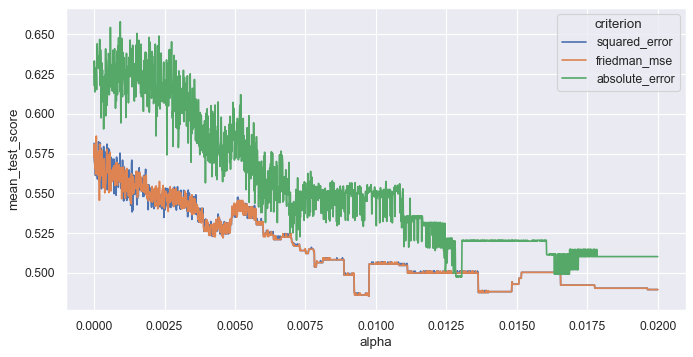

In [ ]:
print(gs.best_estimator_)
sns.set(rc = {'figure.figsize':(10,5)})
sns.lineplot(x='alpha', y='mean_test_score', data=cv_res,hue='criterion')
plt.show()

Let's have a closer look at the fitted model with the best performance parameters. The optimal RMSE is 0.3898, fit plot and residual plot also show relatively satisfactory performance.

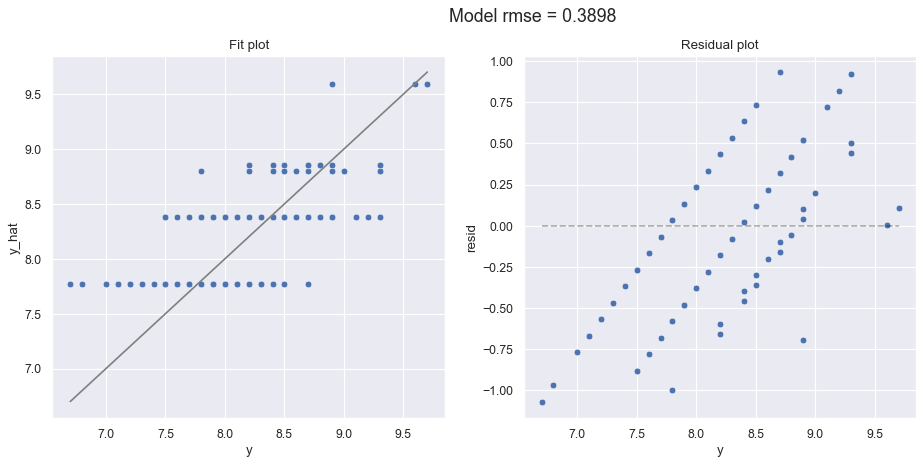

0.38976785010954496

In [ ]:
model_fit(gs.best_estimator_, X, y, plot=True)

At the end of this section, we visualize our final decision tree, and provide a scatterplot using t-SNE. 

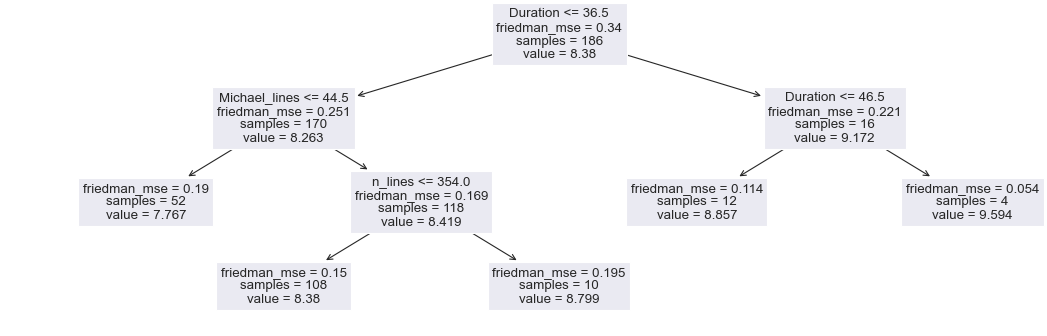

In [ ]:
col_trans = gs.best_estimator_.named_steps['columntransformer']

features_names= col_trans.get_feature_names_out()               

cat_feature_names = col_trans.named_transformers_["One hot"].get_feature_names_out()    # This get all the categorical features' names.
for i in range(len(cat_feature_names)):                       
    features_names[i] = cat_feature_names[i]
for i in range(len(features_names)):
    features_names[i] = re.sub("remainder__", 
        "",
        features_names[i])    
fig = plt.figure(figsize=(16,5))
fig = plot_tree(gs.best_estimator_.named_steps['decisiontreeregressor'],feature_names= features_names,fontsize=12)
None 

From the above decision tree plot, we can see that when the duration of an episode is longer than 36.5 minutes, no other factors matters, and episodes that are longer than 46.5 minutes have higher ratings than any other ones. This tells us that our special reunion episode should be relatively long, which can therefore present more contents and satisfy the audience's curiosity for the character's future development.

On the other hand, if due to the limitations of budget or some other reasons, the special episode cannot be longer than 36.5 minutes, we can still get a satisfactory rating by assigning more than 44 lines to Michael with a total number of lines larger than 354. This also reveals the importance of rich content in our special episode as well as Michael's place in the hearts of audience.

However, as a common knowledge, the number of spoken lines itself may not directly contribute to the rating, because an episode can be lengthy and boring at the same time. And based on the first hotmap above, the correlation of spoken lines with duration is 0.66. We can consider only the effect of duration on episode rates, not both.

In [ ]:
# It is strange to have "air_data_month" as a predictor
d.loc[(d.Duration> 36.5)].head(5)

,Duration,GuestStars,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,...,Kelly_lines,Kevin_lines,Meredith_lines,Michael_lines,Oscar_lines,Pam_lines,Phyllis_lines,Ryan_lines,Stanley_lines,Toby_lines
37,42,False,3,10,A Benihana Christmas (Parts 1&2),Harold Ramis,Jennifer Celotta,8.7,2541,2006-12-14,...,5.0,14.0,3.0,109.0,1.0,57.0,12.0,8.0,3.0,8.0
50,42,False,3,24,The Job (Parts 1&2),Ken Kwapis,Paul Lieberstein;Michael Schur,9.3,3010,2007-05-17,...,3.0,17.0,6.0,114.0,10.0,42.0,4.0,4.0,7.0,0.0
51,42,False,4,1,Fun Run (Parts 1&2),Greg Daniels,Greg Daniels,8.8,2826,2007-09-27,...,6.0,17.0,18.0,130.0,9.0,81.0,4.0,7.0,9.0,9.0
52,42,False,4,3,Dunder Mifflin Infinity (Parts 1&2),Craig Zisk,Michael Schur,8.4,2248,2007-10-04,...,19.0,13.0,0.0,139.0,3.0,50.0,13.0,78.0,5.0,18.0
53,42,True,4,5,Launch Party (Parts 1&2),Ken Whittingham,Jennifer Celotta,8.5,2173,2007-10-11,...,8.0,14.0,12.0,146.0,8.0,24.0,8.0,6.0,7.0,0.0


### 3.3 Evaluation

Next, we will implement t-SNE[<sup>1</sup>](#fn1) (suitable for nonlinear structure of data) to visualize the effect of our model.


We start by copying the original dataframe and add two columns for residual and prediction. We would like to map the data into the two-dimensional space, on which we compare the predicted value of our model and the true response. The data are encoded for categorical variables and standard-scaled before all as required by the algorithm. 

In [ ]:
resid = y - gs.best_estimator_.predict(X) 
check_dat = d.copy()
check_dat['resid'] = resid
check_dat['pred'] = gs.best_estimator_.predict(X) 

From workshop 3 and the document of [Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html), we know that T-distributed Stochastic Neighbor Embedding (t-SNE): is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results. Therefore, we choose this method to visualize our fitting performance.



D:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


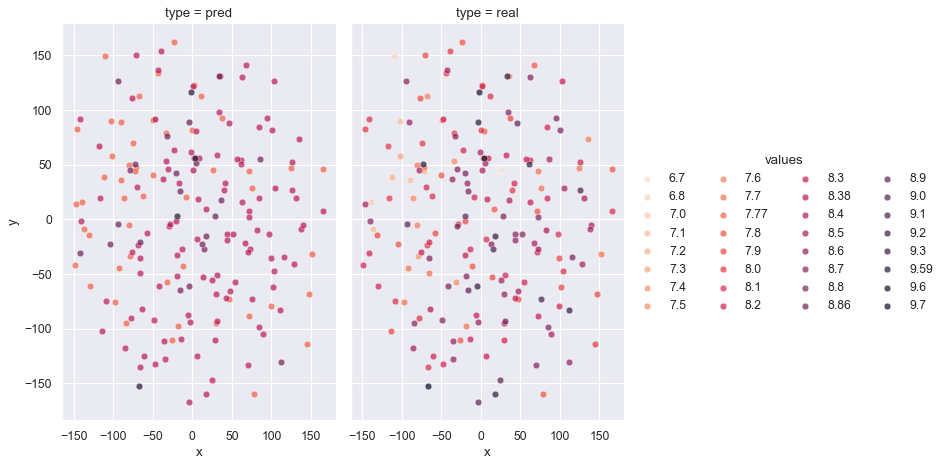

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
visualization_preprocessor = ColumnTransformer(transformers=[('One hot',one_hot, selector(dtype_include="category")),
                            ('Scaler',StandardScaler(), selector(dtype_include="number"))]) 
tsne = TSNE(n_components=3, perplexity = 10, random_state= 123 , init = "pca", learning_rate=200) #Initialization using PCA
data_tsne = tsne.fit_transform(visualization_preprocessor.fit_transform(X))
df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y','z'])
df_tsne = pd.concat([df_tsne,df_tsne],axis = 0)
df_tsne['values'] = np.concatenate([np.around(gs.best_estimator_.predict(X),2),y])
df_tsne['type'] = ['pred' for i in range(len(d))] + ['real' for i in range(len(d))]


#-v-v-v-v- Plot your clustered data for both x and y as a scatter plot. -v-v-v-v
#-v-v-v-v- Write your code here -v-v-v-v
#set_xlim((df_tsne.min()['x']-1,df_tsne.max()['x']+1))
num_values = len(df_tsne['values'].unique())

g = sns.FacetGrid(df_tsne, hue= "values", col = "type",palette = sns.color_palette("rocket_r",num_values),
 height= 6, aspect=0.7)
g.map(sns.scatterplot, "x", "y", alpha=.7)
g.add_legend(ncol = 4)

<span id="fn1">[Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html): *"T-distributed Stochastic Neighbor Embedding (t-SNE): is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. t-SNE has a cost function that is not convex, i.e. with different initializations we can get different results."*  </span>

## 4. Discussion & Conclusions


In [71]:
from sklearn import set_config
set_config(display="diagram")
pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('One hot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001F60BA17640>)])),
                ('decisiontreeregressor', DecisionTreeRegressor())])

<b>1. Overview of the final model</b>  
In this project, we investigated Linear Model with Lasso, Regression Trees, Support Vector Regression and Polynomial Regression. And finally choose to build a regression tree model, which has the smallest rmse and the best fit effectiveness among these four models. 

As for Regression tree, first we use one-hot eccoding to transfer categorical variables. And then we create a pipeline that contains one-hot transformer and regression tree estimator to search suitable parameters. After modeling, we calculate mean_test_score for different criterion. Mean test score shows that when alpha value equals to 0.00976 under Friedman's improvement will get a better model. This better model's rmse is 0.3898 which is smaller than linear model' rmse. <br> After ploting the model by t-SNE, we can get the conclusion that episode duration, Michael's spoken lines and the number of all characteristic spoken lines are influential factors to achieve higher rating.

According to the results, if we want to design a high rate episode, the duration time should around 36-46 minutes and Michael needs to speak more than 44 lines in each episode.

<b>2. Why do we prefer the regression tree model?</b>  
The regression tree model is preferred than linear models (Lasso, Ridge) for several reasons. 
Firstly, due to the stepwise tree structure, it is good at revealing the interactions between features in the data. The tree can grow very deep to exploit all possible interaction effect and significant features. Secondly, the interpretation is easier than the linear model which assumes one feature increases while the other features stay unchanged. Another beauty in regard to the interpretation is that the tree model does not require scaling which makes the interpretation straightforward, while the scaling is mandatory in methods such as Lasso model, Ridge Regression. Finally, the tree allows pruning to increase its generalization ability and in our project, which is achieved by the applicaiton of 5-fold Cross-Validation scheme. Thus this model is flexible, readily interpretable, robust and is chosen for this project.

<b>3. Implication of the model </b>  
As seen in the plotted tree, the nearer one split is to the root, the more importance that feature has. So in this problem, the feature 'Duration' has the biggest influence on the rating and the presence of the main character Michael has the secondary influence and the number of spoken lines in episode (n_lines) has the least importance. If we have a closer look on the episodes with duration longer than 36.5, these episodes excluding actually consists of two parts - labelled as "(Parts 1&2)", such as "A Benihana Christmas (Parts 1&2)", except for "Moving On", "Livin' the Dream". It implies that the audience are possibly more attracted to the episodes with rich contents and plentiful plot twists. 

<b>4. Recommendation</b> 
Overall, in this project, our objective in building regression tree model is to give advice to a highest rated reunion episode. According to the results, the episode duration can be set around 36-46 minutes and we highly recommend inviting the actor Steve Carell who plays Michael to participate in. The model above implies that Michael is extremely favorable. There are 49 episodes where Michael is absent and most of these episodes receive significantly lower rating except for those with longer duration and rich content.  
<br>
